# Preprocessing Bear Hearthrate Data 
- Sample collected from `https://datadryad.org/stash/dataset/doi:10.5061/dryad.6tt0h5s`.


In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv('heartrate_data.txt', delimiter=';', quotechar='"')
df.head()
df.drop(columns=['DenningDay','BodyMass','PreDenDay'],inplace=True)

In [7]:
df['GMT_date'] = pd.to_datetime(df['GMT_date'])
date_intervals = df.groupby('Object_ID')['GMT_date'].agg(['min', 'max'])
longest_interval_object = (date_intervals['max'] - date_intervals['min']).idxmax()

df =df[df['Object_ID']==longest_interval_object]
df.head()

,Object_ID,HeartRate,GMT_date,Species
0,W1304,68.725000,2016-05-12 11:59:32,Brown
1,W1304,56.859722,2016-05-13 11:59:32,Brown
2,W1304,64.465278,2016-05-14 11:59:32,Brown
3,W1304,66.461111,2016-05-15 11:59:32,Brown
4,W1304,64.163889,2016-05-16 11:59:32,Brown


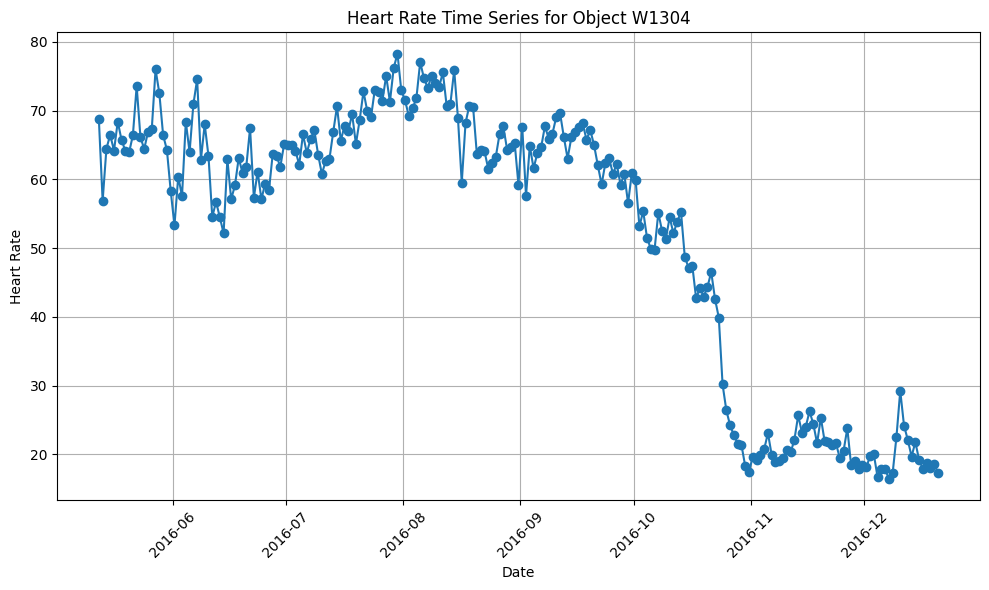

In [8]:
import matplotlib.pyplot as plt

df_filtered = df[df['Object_ID'] == 'W1304']
df_filtered['original_data'] = True
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['GMT_date'], df_filtered['HeartRate'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Heart Rate')
plt.title('Heart Rate Time Series for Object W1304')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Filling missing data
the image is taken from https://www.nature.com/articles/srep40732

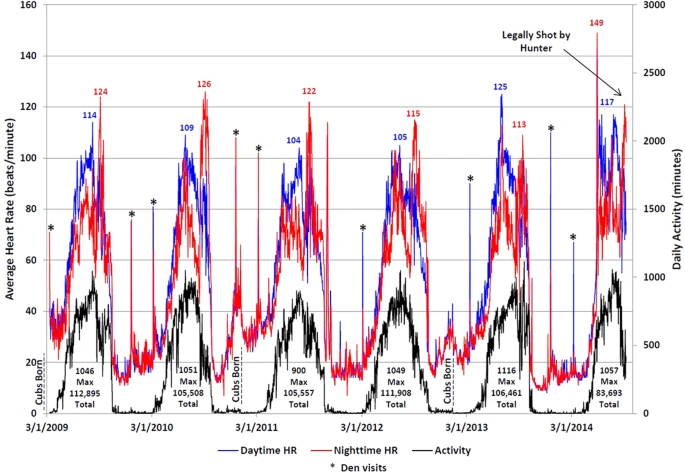


the image is taken from https://www.researchgate.net/publication/51578380_Monitoring_the_wild_black_bear's_reaction_to_human_and_environmental_stressors

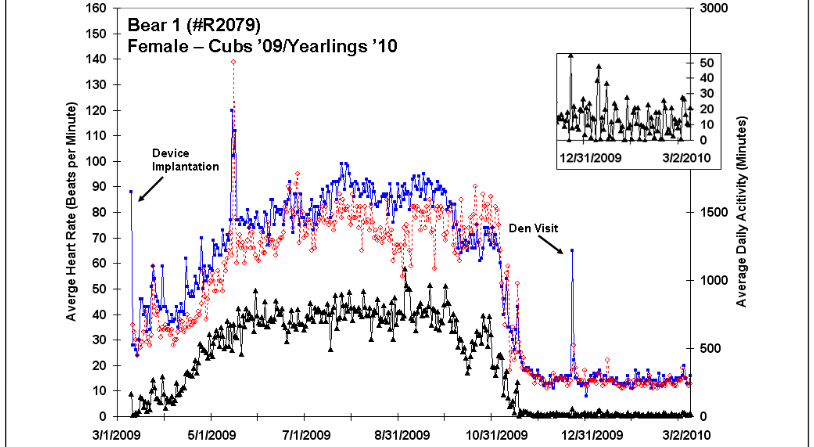


## Observations
From the images we can see that bears hibernate until April. then heartrate gradually increases from there. To have a whole sample to generate stream after that, I will try to fill the missing days of the year from our dataset. 

## Generating remaining hibernation
So my approach to generate data until April (end of hibernation), is to compute distribution statistics of data in hibernation. and generate data with similar statistics after that.

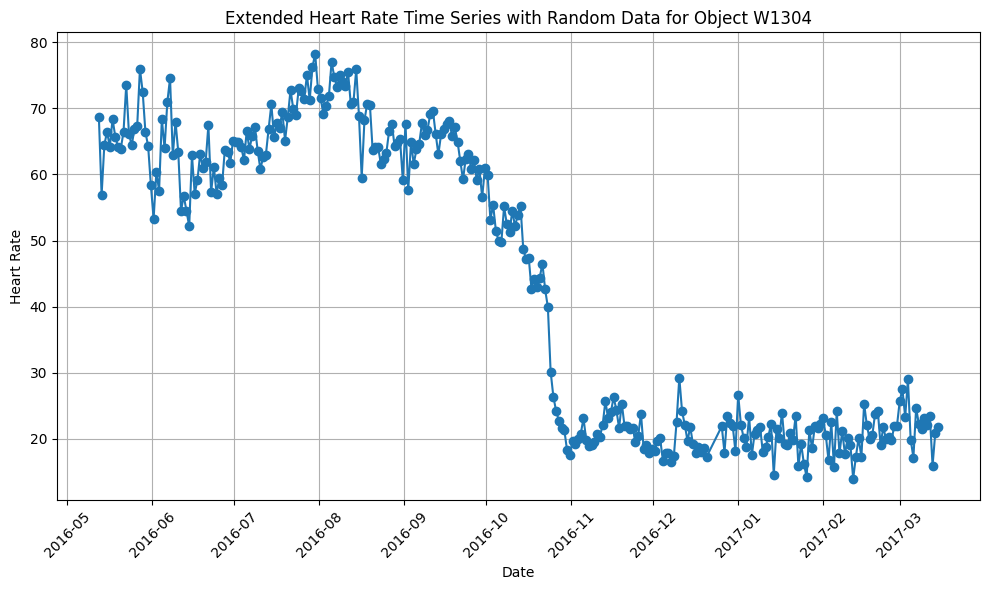

In [9]:
new_dates = pd.date_range(start='2016-12-26', periods=80, freq='D')
count_days = len(new_dates)



start_date = '2016-11-01'
end_date = '2016-12-15'

# Calculate Stats of the data. 
interval_data = df_filtered[(df_filtered['GMT_date'] >= start_date) & (df_filtered['GMT_date'] <= end_date)]
mean_hr = interval_data['HeartRate'].mean()
std_hr = interval_data['HeartRate'].std()

# Create new random data.
def generate_random_data(mean, std, count):
    return np.random.normal(loc=mean, scale=std, size=count)
random_heartrate_data = generate_random_data(mean_hr, std_hr, count_days)
new_random_data = pd.DataFrame({
    'Object_ID': 'W1304',
    'HeartRate': random_heartrate_data,
    'GMT_date': new_dates,
    'Species': 'Brown'
})

# Append the new random data 
df_filtered_extended_random = pd.concat([df_filtered, new_random_data], ignore_index=True)


plt.figure(figsize=(10, 6))
plt.plot(df_filtered_extended_random['GMT_date'], df_filtered_extended_random['HeartRate'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Heart Rate')
plt.title('Extended Heart Rate Time Series with Random Data for Object W1304')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Data looks aligned with the existing hibernation data with a small issue. The existing data naturally showing gradual changes. However, our generated data shows jumps which is not natural to have that frequently. The changes should be gradually. To measure this, I have used `first order difference metric` below. Which basicly shows the mean of the size of steps between data. And from this metric I have assured the problem.



In [10]:
def mean_first_order_diff(list):
    return np.mean(np.abs(np.diff(list)))

original_graduality = mean_first_order_diff(interval_data['HeartRate'])
generated_graduality = mean_first_order_diff(new_random_data['HeartRate'])
print("original_graduality: ", original_graduality)
print("generated_graduality: ", generated_graduality)


original_graduality:  1.8791666666666644
generated_graduality:  3.2943214340123412


To address this, I have introduced steps. So the data follows steps randomly generated (tuned by standard deviation).

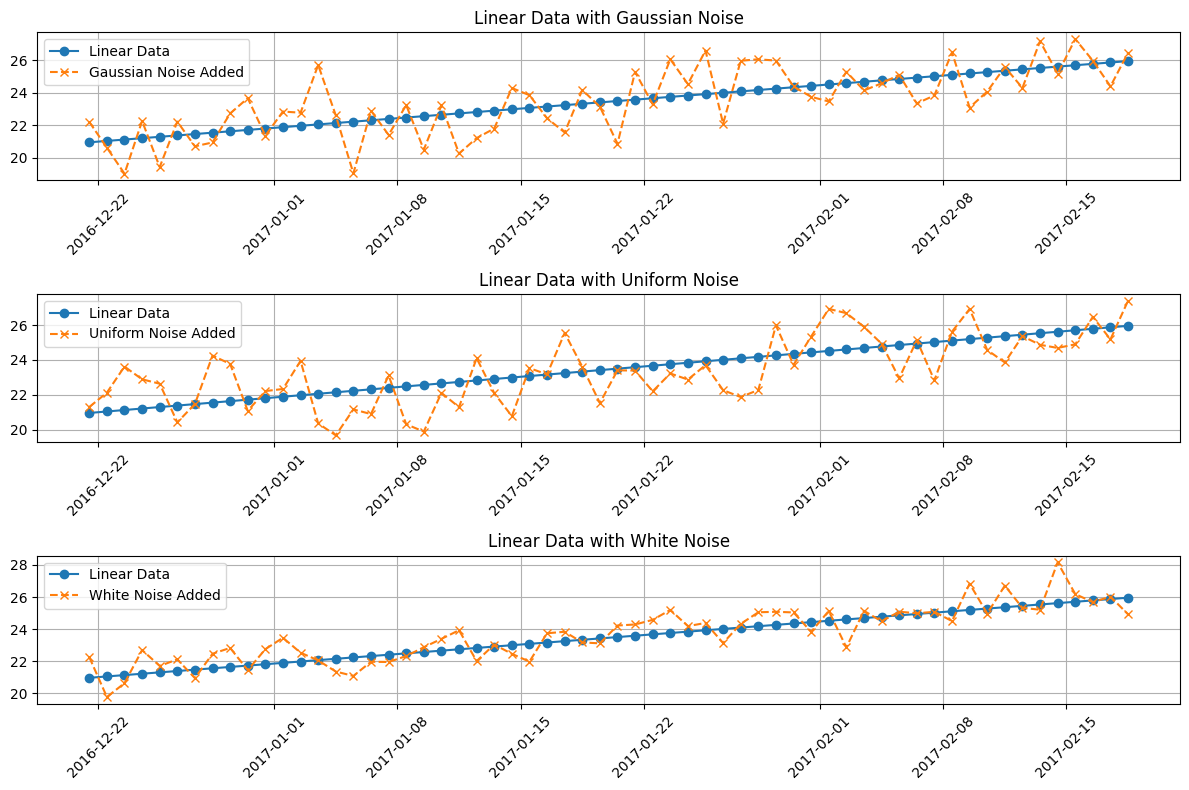

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

count_days = 60
linear_values = np.linspace(mean_hr, mean_hr + 5, count_days)
dates = pd.date_range(start=df_filtered['GMT_date'].max() + pd.Timedelta(days=1), periods=count_days)

gaussian_noise = np.random.normal(loc=0, scale=std_hr/2, size=count_days)
uniform_noise = np.random.uniform(low=-std_hr, high=std_hr, size=count_days)
white_noise = np.random.normal(loc=0, scale=std_hr/3, size=count_days)

gaussian_data = linear_values + gaussian_noise
uniform_data = linear_values + uniform_noise
white_noise_data = linear_values + white_noise

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(dates, linear_values, label='Linear Data', linestyle='-', marker='o')
plt.plot(dates, gaussian_data, label='Gaussian Noise Added', linestyle='--', marker='x')
plt.title('Linear Data with Gaussian Noise')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(dates, linear_values, label='Linear Data', linestyle='-', marker='o')
plt.plot(dates, uniform_data, label='Uniform Noise Added', linestyle='--', marker='x')
plt.title('Linear Data with Uniform Noise')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(dates, linear_values, label='Linear Data', linestyle='-', marker='o')
plt.plot(dates, white_noise_data, label='White Noise Added', linestyle='--', marker='x')
plt.title('Linear Data with White Noise')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


original_graduality:  1.8791666666666644
generated_graduality:  1.3834771078275887
original_graduality:  1.8791666666666644
generated_graduality:  1.6125155768176302
original_graduality:  1.8791666666666644
generated_graduality:  1.3801502919354658
original_graduality:  1.8791666666666644
generated_graduality:  1.971128065879308
original_graduality:  1.8791666666666644
generated_graduality:  1.971128065879308


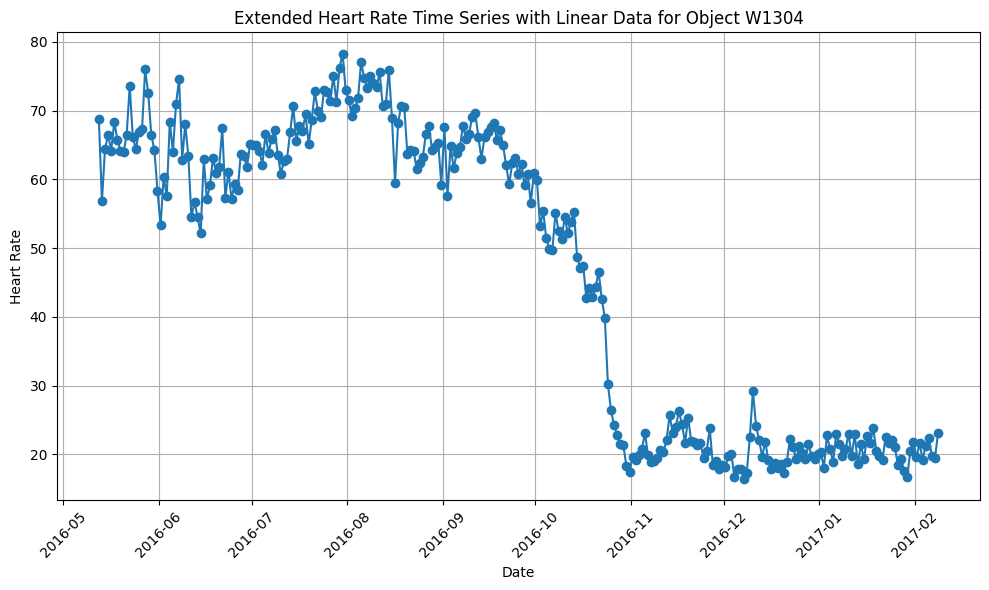

2.7471493492130983


In [12]:

destination_value = mean_hr
count_days = 50
linear_values = np.linspace(mean_hr, destination_value, count_days)

while True:
    white_noise = np.random.normal(loc=0, scale=std_hr/2, size=count_days)
    noisy_data=white_noise+linear_values

    original_graduality = mean_first_order_diff(interval_data['HeartRate'])
    generated_graduality = mean_first_order_diff(noisy_data)
    print("original_graduality: ", original_graduality)
    print("generated_graduality: ", generated_graduality)
    if abs(original_graduality-generated_graduality) <0.15:
        break

print("original_graduality: ", original_graduality)
print("generated_graduality: ", generated_graduality)
new_linear_data = pd.DataFrame({
    'Object_ID': 'W1304',
    'HeartRate': noisy_data,
    'GMT_date': pd.date_range(start=df_filtered['GMT_date'].max() + pd.Timedelta(days=1), periods=count_days),
    'Species': 'Brown'
})

df_filtered_extended_linear = pd.concat([df_filtered, new_linear_data], ignore_index=True)

plt.figure(figsize=(10, 6))
plt.plot(df_filtered_extended_linear['GMT_date'], df_filtered_extended_linear['HeartRate'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Heart Rate')
plt.title('Extended Heart Rate Time Series with Linear Data for Object W1304')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

print(std_hr)

## Generating Hibernation - Summer Transition

In order to complete a season cycle, I need data until 5th month of new year. Generated a linear data first as below.

original_graduality:  1.8791666666666644
generated_graduality:  1.7242509096751064
original_graduality:  1.8791666666666644
generated_graduality:  1.697134462832521
original_graduality:  1.8791666666666644
generated_graduality:  1.5046044744730642
original_graduality:  1.8791666666666644
generated_graduality:  1.6332171698064581
original_graduality:  1.8791666666666644
generated_graduality:  1.646683250743784
original_graduality:  1.8791666666666644
generated_graduality:  1.4848669210993835
original_graduality:  1.8791666666666644
generated_graduality:  1.7422122974845395
original_graduality:  1.8791666666666644
generated_graduality:  1.66877487437008
original_graduality:  1.8791666666666644
generated_graduality:  1.7888874251146742
original_graduality:  1.8791666666666644
generated_graduality:  1.464255368088655
original_graduality:  1.8791666666666644
generated_graduality:  1.5305870043541452
original_graduality:  1.8791666666666644
generated_graduality:  1.7479539616769384
original_

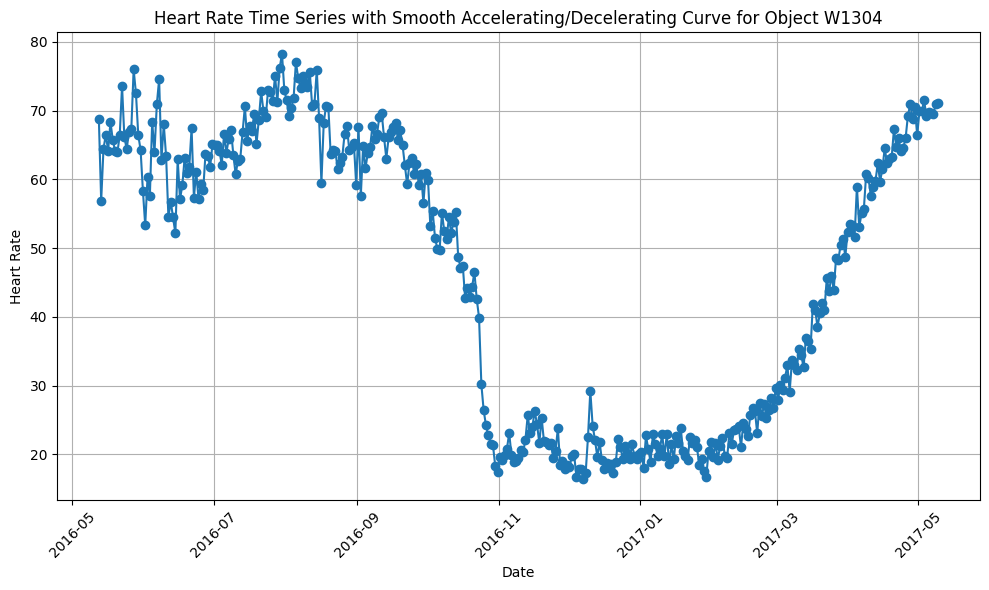

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_filtered_extended_sorted = df_filtered_extended_linear.sort_values(by='GMT_date')
latest_value = df_filtered_extended_sorted['HeartRate'].iloc[-1]
latest_date = df_filtered_extended_sorted['GMT_date'].iloc[-1]

destination_date = pd.Timestamp('2017-05-10')
destination_value = 70
interval_dates = pd.date_range(start=latest_date + pd.Timedelta(days=1), end=destination_date)
count_days=len(interval_dates)
interval_length = len(interval_dates)

t = np.linspace(0, np.pi, interval_length)  
cosine_values = (1 - np.cos(t)) / 2  
curve_values = latest_value + cosine_values * (destination_value - latest_value)  

while True:
    white_noise = np.random.normal(loc=0, scale=std_hr/2, size=count_days)
    noisy_data=white_noise+curve_values

    generated_graduality = mean_first_order_diff(noisy_data)
    print("original_graduality: ", original_graduality)
    print("generated_graduality: ", generated_graduality)
    if abs(original_graduality +0.15) < generated_graduality:
        break


interval_data = pd.DataFrame({
    'Object_ID': 'W1304',
    'HeartRate': noisy_data,
    'GMT_date': interval_dates,
    'Species': 'Brown'
})

df_filtered_extended_final = pd.concat([df_filtered_extended_sorted, interval_data], ignore_index=True)

plt.figure(figsize=(10, 6))
plt.plot(df_filtered_extended_final['GMT_date'], df_filtered_extended_final['HeartRate'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Heart Rate')
plt.title('Heart Rate Time Series with Smooth Accelerating/Decelerating Curve for Object W1304')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


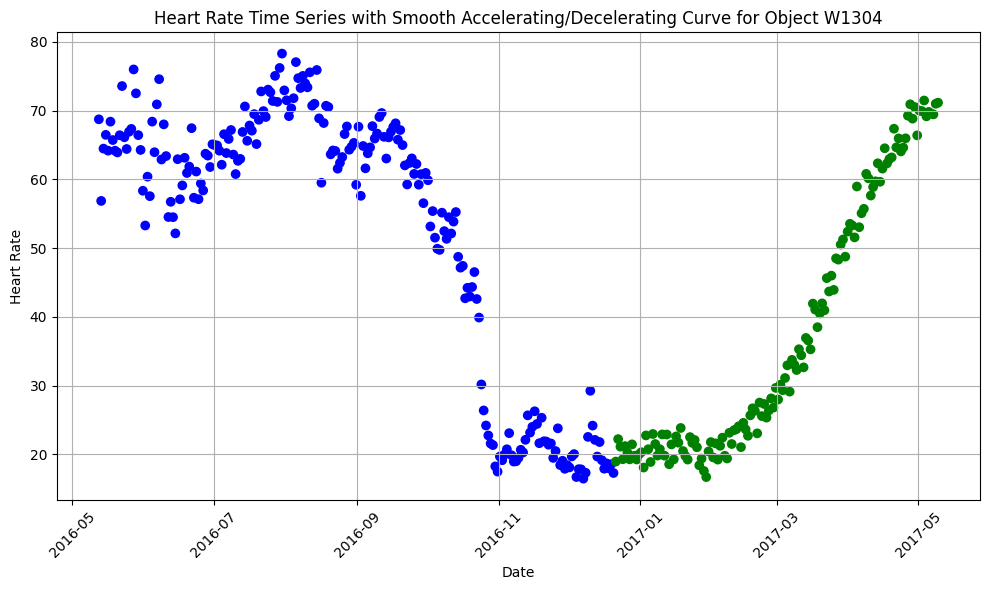

In [18]:
df_filtered_extended_final['original_data'].fillna(False, inplace=True)
plt.figure(figsize=(10, 6))
colors = df_filtered_extended_final['original_data'].apply(lambda x: 'green' if not x else 'blue')
plt.scatter(df_filtered_extended_final['GMT_date'], df_filtered_extended_final['HeartRate'], c=colors, marker='o')
plt.xlabel('Date')
plt.ylabel('Heart Rate')
plt.title('Heart Rate Time Series')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
df_filtered_extended_final.to_csv('df_filtered_extended_final.csv', index=False)